In [162]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import yaml 
import os 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [163]:
# Simulation Date
sysname = "VeGAN"
version = 'november'
gen_size = 1000
data_dir = Path(f'../artifacts/results_{version}/')

In [164]:
cfg = yaml.safe_load(open('../config/config.yaml'))
attack_index_dict = {attack : indx for indx, attack in enumerate(cfg['selected_attacks'])}
if not os.path.exists("../artifacts/plots/"): 
	os.makedirs("../artifacts/plots/") 

# Gather all Data for WGAN

### Get GS for all the generators


In [165]:
gen_files = glob.glob(f'../artifacts/results_{version}/gen*.json')

gen_eval_df = pd.DataFrame([])
for gen_file_name in gen_files:
    model_id = "_".join( Path(gen_file_name).name.split("_")[1:-1])
    with open(f"{gen_file_name}", "r") as fp: 
        gen_score = json.load(fp)
    gen_eval_df[model_id] = pd.Series(gen_score)
gen_eval_df

,wgan_8_5_16_50_1000,wgan_8_3_16_25_1000,wgan_8_3_64_25_1000,wgan_8_3_48_100_1000,wgan_8_5_64_25_1000,wgan_8_5_48_100_1000,wgan_8_3_48_50_1000,wgan_8_4_48_25_1000,wgan_8_5_64_75_1000,wgan_8_4_64_25_1000,...,wgan_8_3_32_25_1000,wgan_8_4_8_25_1000,wgan_8_3_16_100_1000,wgan_8_4_48_100_1000,wgan_8_3_16_75_1000,wgan_8_5_64_100_1000,wgan_8_3_8_100_1000,wgan_8_4_8_50_1000,wgan_8_4_32_75_1000,wgan_8_5_32_100_1000
W_Distance,0.001376,0.002583,0.001918,0.001373,0.001688,0.001535,0.002219,0.002030,0.001737,0.002474,...,0.002485,0.003155,0.001156,0.001574,0.001563,0.001304,0.001213,0.001847,0.001623,0.001206
FID_Score,0.290087,0.196638,1.310975,0.084789,4.530229,0.063862,0.063737,0.538737,0.173437,2.015711,...,0.110078,5.648771,0.034057,0.112162,0.085295,0.066055,0.079445,0.046148,0.129572,0.168897
KID_Score,0.194643,0.048019,0.909069,0.055175,3.111844,0.029758,0.031885,0.391322,0.104734,1.142074,...,0.023356,3.200819,0.020648,0.050690,0.061595,0.039470,0.035290,0.025653,0.086247,0.115051


### Get DS for all the discriminator

In [166]:
# Get ADS for all the discriminator
dis_files = glob.glob(f'../artifacts/results_{version}/dis*.json')

dis_eval_df = pd.DataFrame([])
for dis_file_name in dis_files:
    model_id = "_".join( Path(dis_file_name).name.split("_")[1:-1])
    with open(f"{dis_file_name}", "r") as fp: 
        dis_score = json.load(fp)
    dis_score = pd.DataFrame(dis_score).T
    dis_score['mAUC'] = dis_score[['AUROC', 'AUPRC']].mean(axis=1)
    dis_eval_df[model_id] = dis_score['AUROC'] #TODO: Change here for another DS metric
dis_eval_df = dis_eval_df.T
indeces = ["_".join(ind.split("_")[0:-1]) for ind in dis_eval_df.index]
dis_eval_df.index  = indeces
dis_eval_df = dis_eval_df.dropna() #TODO: Evaluate the metrics again (Nan)
dis_eval_df.head(5)

,RandomPositionOffset,ConstantPositionOffset,RandomSpeed,RandomSpeedOffset,ConstantSpeed,ConstantSpeedOffset,LowSpeed,RandomAcceleration,RandomAccelerationOffset,ConstantAccelerationOffset,...,RandomHeading,RandomHeadingOffset,OppositeHeading,RandomYawRate,RandomYawRateOffset,ConstantYawRate,HighYawRate,RandomHeadingYawRateOffset,ConstantHeadingYawRateOffset,LowHeadingYawRate
wgan_8_4_64_75,0.998058,0.644355,0.935828,0.739452,0.592844,0.144783,0.745945,0.740928,0.73631,0.832213,...,1.0,1.0,0.572962,0.93822,0.669988,0.29976,0.982863,0.998327,1.0,1.0
wgan_8_3_48_75,0.991013,0.498591,0.986688,0.532634,0.764187,0.900454,0.226502,0.760815,0.656157,0.726681,...,1.0,1.0,0.810598,0.888689,0.796369,0.839565,0.982863,0.996526,1.0,1.0
wgan_8_5_64_25,0.527623,0.478031,0.562592,0.404694,0.515237,0.869645,0.200701,0.789095,0.551785,0.559099,...,0.203881,0.261008,0.781766,0.588414,0.677473,0.792224,1.0,0.288435,0.499069,0.488659
wgan_8_3_8_100,0.997299,0.620666,0.949197,0.71278,0.847081,0.934602,0.290794,0.257909,0.159483,0.800342,...,1.0,1.0,0.924293,0.676967,0.013609,0.851847,0.978579,0.99005,1.0,1.0
wgan_8_4_8_75,0.992502,0.583854,0.62929,0.524595,0.397447,0.0,0.302752,0.795422,0.691854,0.514875,...,1.0,0.999516,0.195897,0.568349,0.999574,0.731699,0.103957,0.981719,0.991822,1.0


### Discriminator Score by Max Baseline


In [167]:
dis_ind_score = pd.DataFrame([])
for dis_file_name in dis_files:
    model_id = "_".join( Path(dis_file_name).name.split("_")[1:-1])
    with open(f"{dis_file_name}", "r") as fp: 
        dis_score = json.load(fp)
    dis_score = pd.DataFrame(dis_score).T
    dis_score['mAUC'] = dis_score[['AUROC', 'AUPRC']].mean(axis=1)
    _, window, no_of_layers, latent_dim, epochs, _ = model_id.split("_")
    dis_score["window"] = int(window)
    dis_score['no_of_layers'] = int(no_of_layers)
    dis_score['latent_dim'] = int(latent_dim)
    dis_score['epochs'] = int(epochs)
    param = model_id.split("_")[0:-1]
    dis_score['Model']  = "_".join(param)
    params = f"$layers$={param[2]}, $noise~dim$={param[3]}, $epoch$={param[4]}"
    dis_score['WGAN Parameter'] = params
    dis_ind_score = pd.concat([dis_ind_score, dis_score], axis= 0, ignore_index=True)

dis_ind_score_max = dis_ind_score.groupby('Attack').max()
dis_ind_score_max['Attack'] = dis_ind_score_max.index

In [168]:
# Replacing attack name with attack index
dis_eval_df.rename(columns=attack_index_dict, inplace=True)
dis_ind_score = dis_ind_score.replace(attack_index_dict)
# dis_ind_score_max = dis_ind_score_max.replace(attack_index_dict)
dis_ind_score_max.rename(index=attack_index_dict, inplace=True)
# dis_eval_df = dis_eval_df.astype(float).round(decimals = 4)
# dis_eval_df

In [169]:
# Select top k models
top_models_df = dis_eval_df.mean(axis = 1).sort_values(ascending=False)
top_models = []
for model_id in top_models_df.index:
    candidate = model_id.split("_")[1:-1]
    if candidate not in top_models:
        top_models.append(candidate)

### Training Stability of top 2 WGAN model (based of ADS)


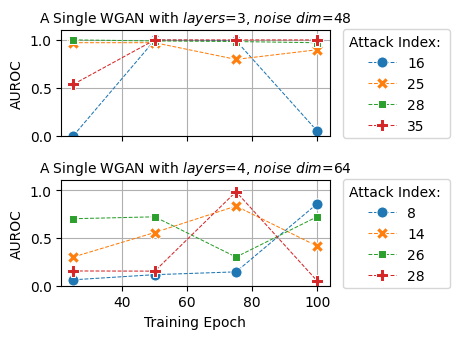

In [170]:
# Training Stability of top 2 WGAN model (based of ADS)

fig, axes = plt.subplots(2, 1, figsize= (5, 3.5), sharex=True)

metric = 'AUROC'
palette = sns.color_palette("mako_r", 6)

for ax, (window, no_of_layers, latent_dim)  in zip(axes, top_models):
    dis_ind_score_cut =  dis_ind_score[dis_ind_score['no_of_layers'] == int(no_of_layers)]
    dis_ind_score_cut =  dis_ind_score_cut[dis_ind_score_cut['latent_dim'] == int(latent_dim)]
    dis_ind_score_cut =  dis_ind_score_cut[dis_ind_score_cut['window'] == int(window)]

    # Selecting four attacks to visualize based on max change in AUROC
    attack_slope = {}
    for attack in dis_ind_score_cut["Attack"].unique():
        score = dis_ind_score_cut[dis_ind_score_cut["Attack"] == attack]['mAUC'].diff().mean()
        attack_slope[attack] = score
    sorted_attacks = list(pd.Series(attack_slope).sort_values().index)
    top_attacks = sorted_attacks[0:2] + sorted_attacks[-2:]
    dis_ind_score_cut  = dis_ind_score_cut[dis_ind_score_cut['Attack'].isin(top_attacks)]

    # TODO: Change mAUC to AUROC
    sns.set_palette("PuBuGn_d")
    ax = sns.lineplot(dis_ind_score_cut, hue = 'Attack', style = 'Attack', linestyle = '--'
                 , y = metric, x = 'epochs', linewidth = '0.75'
                 , markersize = '8', dashes=False,  markers = True, palette="tab10", ax = ax) #marker = 'p', markers = True, 

    ax.legend(title = "Attack Index: ", bbox_to_anchor = (1.25,1.075), loc='upper center', fontsize = '10')
    ax.set_title(f"A Single WGAN with $layers$={no_of_layers}, $noise~dim$={latent_dim}", fontsize = '10')
    ax.grid(True)
    ax.set_ylim([0.0, 1.1])

plt.xlabel("Training Epoch")


plt.tight_layout()
plt.savefig(f"../artifacts/plots/multiple_attacks_{metric}_WGAN.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/multiple_attacks_{metric}_WGAN.pdf")
plt.show()

### Performance of top three WGAN models

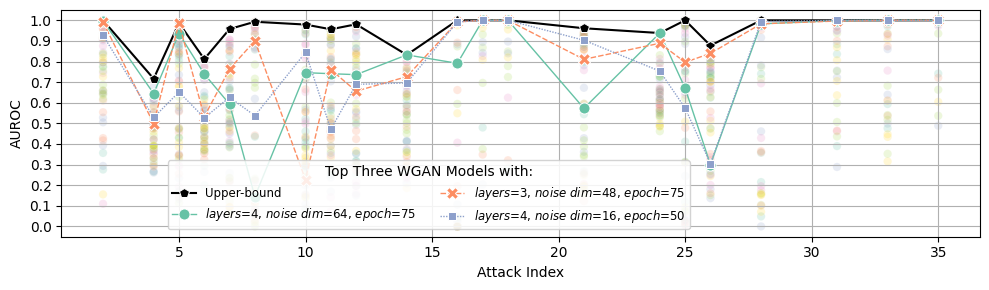

In [171]:
fig, ax = plt.subplots(1, 1, figsize= (10, 3),sharex=True)
mask = dis_ind_score['Model'].isin(list(top_models_df.index[0:3]))
sns.lineplot(dis_ind_score_max.replace(attack_index_dict).sort_values([metric], ascending=False), x = 'Attack', y = metric,  label = "Upper-bound", color = 'k',markersize = '7', marker="p", ax = ax)
sns.scatterplot(dis_ind_score, x = 'Attack', y = metric, hue = 'Model',  markers=True, palette=sns.mpl_palette("Set2"), legend=None, color = 'k', alpha = 0.20, ax = ax)
sns.lineplot(dis_ind_score[mask], x = 'Attack', y =metric, hue = 'WGAN Parameter', style = 'WGAN Parameter', linewidth = '1', markers = True, palette=sns.mpl_palette("Set2"), markersize = '8', ax = ax)
plt.yticks(np.array(range(0, 110, 10))/100)
ax.legend(title = "Top Three WGAN Models with:", bbox_to_anchor = (0.4, 0.185), loc = 'center', ncols = 2, framealpha=0.85, fontsize=8.5) #bbox_to_anchor = (0.3, 0.20),
ax.grid(True)
ax.set_xlabel("Attack Index")
plt.tight_layout()
plt.savefig("../artifacts/plots/max_scores_top_score_all_attacks_WGAN.jpg", dpi = 350)
plt.savefig("../artifacts/plots/max_scores_top_score_all_attacks_WGAN.pdf")
plt.show()

## Ensemble-based VeGAN

In [172]:
# Load correlation coefficient between G & D
corr_gen_dis_dir = Path(f'{data_dir}/correlation_gen_dis.csv')
corr_gen_dis = pd.read_csv(corr_gen_dis_dir, index_col=0)
col_rename = {"W_Distance" : "WD", "FID_Score" : "FID", "KID_Score" : "KID"}
corr_gen_dis.rename(columns = col_rename, index=col_rename, inplace=True)

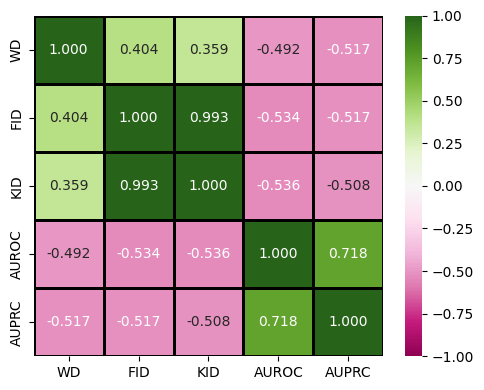

In [173]:
indeces = list(col_rename.values()) + ['AUROC', 'AUPRC']
plt.figure(figsize=(5,4))
sns.heatmap(corr_gen_dis.loc[indeces, indeces], cmap="PiYG", linewidths='2', linecolor='k', annot=True, fmt='.3f',
            vmin=-1, vmax=1)
plt.tight_layout()
plt.savefig("../artifacts/plots/correlation_heapmap_WGAN.jpg", dpi = 350)
plt.savefig("../artifacts/plots/correlation_heapmap_WGAN.pdf")
plt.show()

In [174]:
ens_perf_ads_dir = data_dir / 'ens_detector_ads.csv'
ens_perf_ags_dir = data_dir / 'ens_detector_ags.csv'

ens_perf_ags = pd.read_csv(ens_perf_ags_dir, index_col=0)
# ens_perf_ags.replace(attack_index_dict, inplace=True)
ens_perf_ags['mAUC'] = ens_perf_ags[['AUROC', 'AUPRC']].mean(axis=1)
ens_perf_ags['Base'] = f'${sysname}_{{AGS}}$'

ens_perf_ads = pd.read_csv(ens_perf_ads_dir, index_col=0)
# ens_perf_ads.replace(attack_index_dict, inplace=True)
ens_perf_ads['mAUC'] = ens_perf_ads[['AUROC', 'AUPRC']].mean(axis=1)
ens_perf_ads['Base'] = f'${sysname}_{{ADS}}$'

ens_perf_ads["Model"] = [f"$VeGAN_{{ADS}}^{{{x}}}$" for x in ens_perf_ads['Ensemble'].values]
ens_perf_ags["Model"] = [f"$VeGAN_{{AGS}}^{{{x}}}$" for x in ens_perf_ags['Ensemble'].values]


In [175]:
ens_perf_max_dir = data_dir / 'max_detector.csv'
ens_perf_max = pd.read_csv(ens_perf_max_dir, index_col=0)
ens_perf_max.replace(attack_index_dict, inplace=True)

In [176]:
# Select the best model for each ensemble 
perf_dis_ads_top = ens_perf_ads[['AUROC', 'AUPRC', 'mAUC','Ensemble']].groupby('Ensemble').mean().sort_values(metric, ascending=False).head(10)
ads_max_count = perf_dis_ads_top.index[0]

perf_dis_ags_top = ens_perf_ags[['AUROC', 'AUPRC', 'mAUC','Ensemble']].groupby('Ensemble').mean().sort_values(metric, ascending=False).head(10)
ags_max_count = perf_dis_ags_top.index[0]

print(f"Best model when {ads_max_count}, and {ags_max_count} models are ensembed in ADS, and AGS, respectively")

Best model when 5, and 17 models are ensembed in ADS, and AGS, respectively


In [177]:
ens_perf_comb = pd.concat([ens_perf_ags, ens_perf_ads], axis = 0)
ens_perf_comb['Model'] = [f"{x[:-1]}^k$" for x in ens_perf_comb['Base'].values]
ens_perf_comb

,Ensemble,Attack,AUROC,AUPRC,mAUC,Base,Model
0_RandomPositionOffset,1,RandomPositionOffset,1.000000,1.000000,1.000000,$VeGAN_{AGS}$,$VeGAN_{AGS}^k$
0_ConstantPositionOffset,1,ConstantPositionOffset,0.534026,0.247457,0.390742,$VeGAN_{AGS}$,$VeGAN_{AGS}^k$
0_RandomSpeed,1,RandomSpeed,0.882760,0.943064,0.912912,$VeGAN_{AGS}$,$VeGAN_{AGS}^k$
0_RandomSpeedOffset,1,RandomSpeedOffset,0.633863,0.800344,0.717104,$VeGAN_{AGS}$,$VeGAN_{AGS}^k$
0_ConstantSpeed,1,ConstantSpeed,0.672125,0.756369,0.714247,$VeGAN_{AGS}$,$VeGAN_{AGS}^k$
...,...,...,...,...,...,...,...
19_ConstantYawRate,20,ConstantYawRate,0.843068,0.750770,0.796919,$VeGAN_{ADS}$,$VeGAN_{ADS}^k$
19_HighYawRate,20,HighYawRate,0.981855,0.191549,0.586702,$VeGAN_{ADS}$,$VeGAN_{ADS}^k$
19_RandomHeadingYawRateOffset,20,RandomHeadingYawRateOffset,0.998933,0.999468,0.999200,$VeGAN_{ADS}$,$VeGAN_{ADS}^k$
19_ConstantHeadingYawRateOffset,20,ConstantHeadingYawRateOffset,1.000000,1.000000,1.000000,$VeGAN_{ADS}$,$VeGAN_{ADS}^k$


### Performance of ensemble-based VeGAN

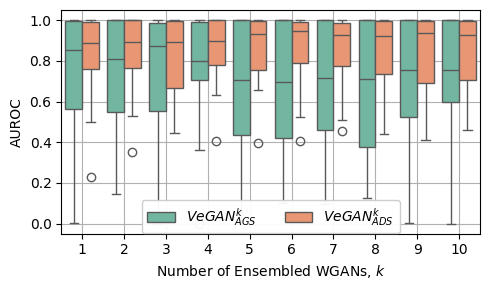

In [178]:
perf_dis_cut = ens_perf_comb[ens_perf_comb['Ensemble'] <=10]
plt.figure(figsize=(5, 3))
sns.boxplot(perf_dis_cut, x = 'Ensemble', y = 'AUROC', hue = 'Model',  palette=sns.mpl_palette("Set2"))
plt.legend( ncols = 2, loc = 'center',  bbox_to_anchor = (0.50, 0.075), framealpha = 0.95) #title = 'VeGAN Model:',
# plt.title("Performance of WGAN-based Ensebmed Detector With Different Model Selection Techniques")
plt.xlabel("Number of Ensembled WGANs, $k$")
plt.grid()
plt.tight_layout()
plt.savefig(f"../artifacts/plots/ensemble_techniques_compared_WGAN.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/ensemble_techniques_compared_WGAN.pdf", dpi = 350)
plt.show()

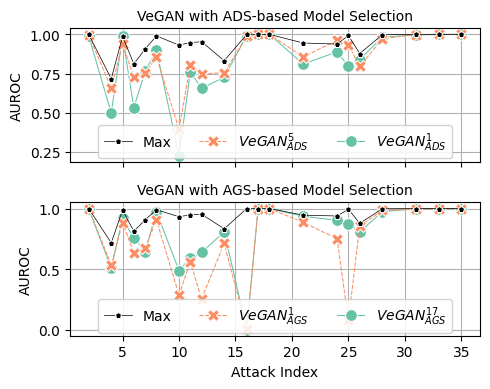

In [179]:
fig, axes = plt.subplots(2,1, figsize = (5, 4),sharex=True)
no_ensemble = 2
sysname = "VeGAN"
metric = "AUROC"

ax = axes[0]
fil_1 = ens_perf_ads['Ensemble'] == 1 
fil_2 = ens_perf_ads['Ensemble'] == ads_max_count 
perf_dis_cut = ens_perf_ads.where(fil_1 | fil_2).dropna()
perf_dis_cut = perf_dis_cut.replace(attack_index_dict)
perf_dis_cut = perf_dis_cut.sort_values('Model', ascending=True)
sns.lineplot(perf_dis_cut.sort_values([metric], ascending=False), x = 'Attack', y = metric,  hue = 'Model',  style = 'Model', linewidth = '0.75', markers=True, markersize = '8.5', palette=sns.mpl_palette("Set2"), ax = ax)
sns.lineplot(ens_perf_max.sort_values([metric], ascending=False), x = 'Attack', y = metric,  label = "Max", color = 'k', marker="p", linewidth = '0.5',  markersize = '5', ax = ax)
ax.grid(True)
handles, labels = axes[0].get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor = (0.5,0.15), loc='center', framealpha = 0.85, ncols = 3)
ax.set_title(f"{sysname} with ADS-based Model Selection", fontsize = '10')


ax = axes[1]
fil_1 = ens_perf_ags['Ensemble'] == 1 
fil_2 = ens_perf_ags['Ensemble'] == ags_max_count 
perf_dis_cut = ens_perf_ags.where(fil_1 | fil_2).dropna()
perf_dis_cut = perf_dis_cut.replace(attack_index_dict)
perf_dis_cut = perf_dis_cut.sort_values('Model', ascending=True)
sns.lineplot(perf_dis_cut.sort_values([metric], ascending=False), x = 'Attack', y = metric,  hue = 'Model',  style = 'Model', linewidth = '0.75', markers=True, markersize = '8.5', palette=sns.mpl_palette("Set2"), ax = ax)
sns.lineplot(ens_perf_max.sort_values([metric], ascending=False), x = 'Attack', y = metric,  label = "Max", color = 'k', marker="p", linewidth = '0.5',  markersize = '5', ax = ax)
ax.grid(True)
ax.set_title(f"{sysname} with AGS-based Model Selection", fontsize = '10')
handles, labels = axes[1].get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor = (0.5,0.15), loc='center', framealpha = 0.85, ncols = 3)
ax.set_xlabel("Attack Index")


plt.tight_layout()
plt.savefig(f"../artifacts/plots/improvements_over_ensemble_WGANs.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/improvements_over_ensemble_WGANs.pdf")
plt.show()

# Baseline Comparison

### Get score for all the autoencoders


In [180]:
ae_files = glob.glob(f'../artifacts/results_{version}/ae*.json')
ae_ind_score = pd.DataFrame([])
ae_eval_df = pd.DataFrame([])
# ae_ind_score = {}
for ae_file_name in ae_files:
    model_id = "_".join( Path(ae_file_name).name.split("_")[1:-1]).split(".")[0]
    with open(f"{ae_file_name}", "r") as fp: 
        ae_score = json.load(fp)
    ae_score = pd.DataFrame(ae_score).T
    ae_score['mAUC'] = ae_score[['AUPRC', 'AUPRC']].mean(axis=1)
    ae_eval_df[model_id] = ae_score['AUROC']
    # ae_ind_score[model_id] = ae_score

    _, window, no_of_layers, epochs = model_id.split("_")
    ae_score["window"] = int(window)
    ae_score['no_of_layers'] = int(no_of_layers)
    ae_score['latent_dim'] = int(0)
    ae_score['epochs'] = int(epochs.split(".")[0])
    ae_score['Model']  = model_id.split(".")[0]
    ae_ind_score = pd.concat([ae_ind_score, ae_score], axis= 0, ignore_index=True)

ae_ind_score_max = ae_ind_score.groupby('Attack').max()
ae_ind_score_max['Attack'] = ae_ind_score_max.index
ae_ind_score_max.head(5)

,AUROC,AUPRC,mAUC,window,no_of_layers,latent_dim,epochs,Model,Attack
Attack,,,,,,,,,
ConstantAccelerationOffset,0.663358,0.75236,0.75236,8,4,0,100,autoencoder_8_4_75,ConstantAccelerationOffset
ConstantHeadingYawRateOffset,0.965749,0.969666,0.969666,8,4,0,100,autoencoder_8_4_75,ConstantHeadingYawRateOffset
ConstantPositionOffset,0.740005,0.365755,0.365755,8,4,0,100,autoencoder_8_4_75,ConstantPositionOffset
ConstantSpeed,0.429598,0.496517,0.496517,8,4,0,100,autoencoder_8_4_75,ConstantSpeed
ConstantSpeedOffset,0.667213,0.013199,0.013199,8,4,0,100,autoencoder_8_4_75,ConstantSpeedOffset


In [181]:
ae_eval_df = ae_eval_df.T
indeces = ["_".join(ind.split(".")[0].split("_")) for ind in ae_eval_df.index]
ae_eval_df.index  = indeces
ae_eval_df.rename(columns=attack_index_dict, inplace=True)
ae_eval_df_top = ae_eval_df.mean(axis = 1).sort_values(ascending=False)
ae_eval_df_top.head(5)

ae_best_detector = ae_ind_score[ae_ind_score["Model"] == ae_eval_df_top.index[0]]
# Loading summary of perf_gen_dis_mean
ae_ind_score.to_csv(f"../artifacts/results_{version}/baseline_autoencoder.csv")
ae_best_detector.to_csv(f"../artifacts/results_{version}/baseline_best_autoencoder.csv")

top_ae_models = []
for model_id in ae_eval_df_top.index:
    candidate = model_id.split("_")[1:-1]
    if candidate not in top_ae_models:
        top_ae_models.append(candidate)
top_ae_models

[['8', '4'], ['8', '3']]

### Top performing AE models

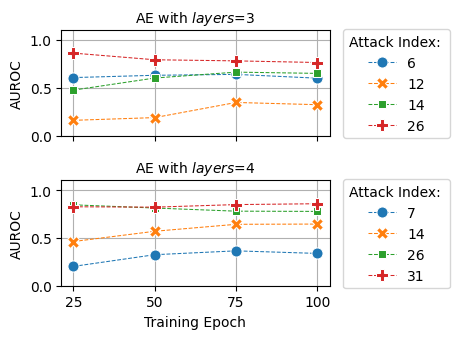

In [182]:
fig, axes = plt.subplots(2, 1, figsize= (5, 3.5), sharex=True)
for ax, (window, no_of_layers)  in zip(axes, top_ae_models[::-1]):
    ae_ind_score_cut =  ae_ind_score[ae_ind_score['no_of_layers'] == int(no_of_layers)]
    attack_slope = {}
    for attack in ae_ind_score_cut["Attack"].unique():
        score = ae_ind_score_cut[ae_ind_score_cut["Attack"] == attack]['mAUC'].diff().mean()
        attack_slope[attack] = score
    sorted_attacks = list(pd.Series(attack_slope).sort_values().index)
    top_attacks = sorted_attacks[0:2] + sorted_attacks[-2:]
    ae_ind_score_cut  = ae_ind_score_cut[ae_ind_score_cut['Attack'].isin(top_attacks)]
    ae_ind_score_cut = ae_ind_score_cut.replace(attack_index_dict)

    # TODO: Change mAUC to AUROC
    sns.set_palette("PuBuGn_d")
    ax = sns.lineplot(ae_ind_score_cut, hue = 'Attack', style = 'Attack', linestyle = '--'
                 , y = metric, x = 'epochs', linewidth = '0.75'
                 , markersize = '8', dashes=False,  markers = True, palette="tab10", ax = ax) #marker = 'p', markers = True, 
    ax.legend(title = "Attack Index: ", bbox_to_anchor = (1.25,1.075), loc='upper center', fontsize = '10')
    ax.set_title(f"AE with $layers$={no_of_layers}", fontsize = '10')
    ax.grid(True)
    ax.set_xticks([25, 50, 75, 100])
    ax.set_ylim([0.0, 1.1])
plt.xlabel("Training Epoch")
plt.tight_layout()
plt.savefig(f"../artifacts/plots/multiple_attacks_{metric}_AE.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/multiple_attacks_{metric}_AE.pdf")
plt.show()

### Getting other baseline models

In [183]:
# Get ADS for all the discriminator
bl_files = glob.glob(f'../artifacts/results_{version}/baseline*.json')
bl_ind_score = pd.DataFrame([])
bl_eval_df = pd.DataFrame([])
for bl_file_name in bl_files:
    print(bl_file_name)
    model_id = "_".join( Path(bl_file_name).name.split("_")[1:-1]).split(".")[0]
    with open(f"{bl_file_name}", "r") as fp: 
        bl_score = json.load(fp)
    bl_score = pd.DataFrame(bl_score).T
    bl_score['mAUC'] = bl_score[['AUPRC', 'AUPRC']].mean(axis=1)
    bl_eval_df[model_id] = bl_score['AUROC']
    bl_score['Model']  = model_id
    bl_score['Base'] =  "Baseline"
    bl_ind_score = pd.concat([bl_ind_score, bl_score], axis= 0, ignore_index=True)

bl_ind_score_max = bl_ind_score.groupby('Attack').max()
bl_ind_score_max['Attack'] = bl_ind_score_max.index

../artifacts/results_november/baseline_MCD_dict.json
../artifacts/results_november/baseline_IForest_dict.json
../artifacts/results_november/baseline_ECOD_dict.json
../artifacts/results_november/baseline_PCA_dict.json
../artifacts/results_november/baseline_DeepSVDD_dict.json
../artifacts/results_november/baseline_LOF_dict.json
../artifacts/results_november/baseline_KNN_dict.json
../artifacts/results_november/baseline_GMM_dict.json


In [184]:
other_baseline = bl_ind_score
ae_baseline = ae_best_detector
ae_baseline['Detector'] = "AE"
ae_baseline['Base'] = "AE"
ae_baseline = ae_baseline.drop(columns = ["Model"])
ae_baseline['Model'] = "AE"

/tmp/ipykernel_234092/2685705797.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ae_baseline['Detector'] = "AE"
/tmp/ipykernel_234092/2685705797.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ae_baseline['Base'] = "AE"


In [185]:
ens_perf_ags_cut = ens_perf_ags[ens_perf_ags['Ensemble'] == ags_max_count]
ens_perf_ads_cut = ens_perf_ads[ens_perf_ads['Ensemble'] == ads_max_count]
final_score = pd.concat([ens_perf_ags_cut, ens_perf_ads_cut, ae_baseline, other_baseline])
final_score_cut = final_score

### Plot the performance comparison

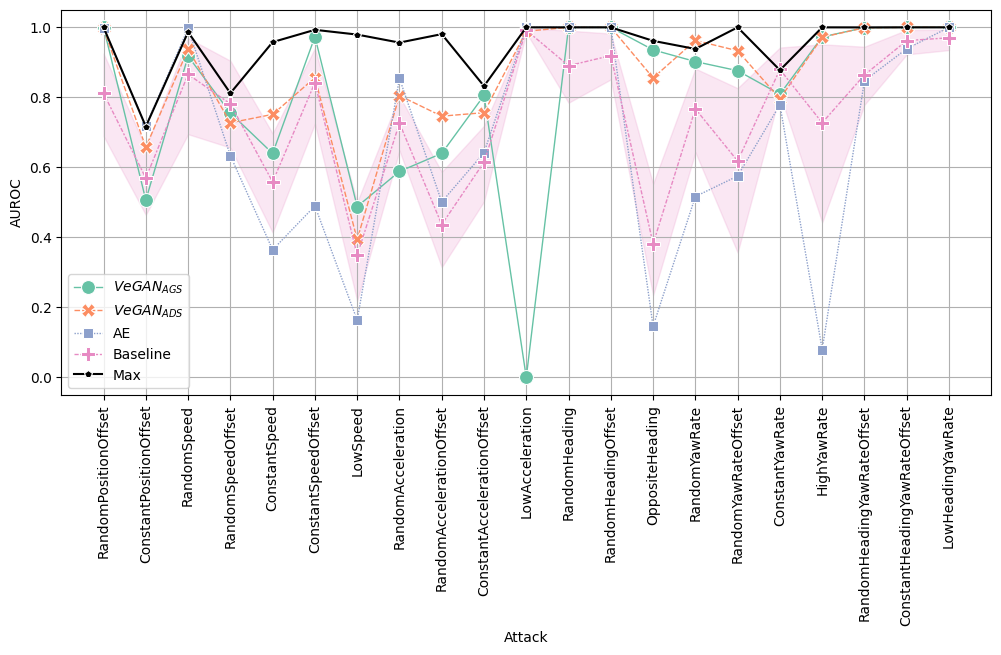

In [186]:
plt.figure(figsize=(12, 5))
sns.lineplot(final_score_cut, x = 'Attack', y = 'AUROC', hue = 'Base', style = 'Base', palette=sns.mpl_palette("Set2"),linewidth = '1', markersize= '10', markers=True)
sns.lineplot(dis_ind_score_max, x = 'Attack', y = 'AUROC',  label = "Max", color = 'k', marker="p")
plt.xticks(rotation = 90)
# plt.yticks(np.array(range(20, 110, 10))/100)
plt.grid(True)

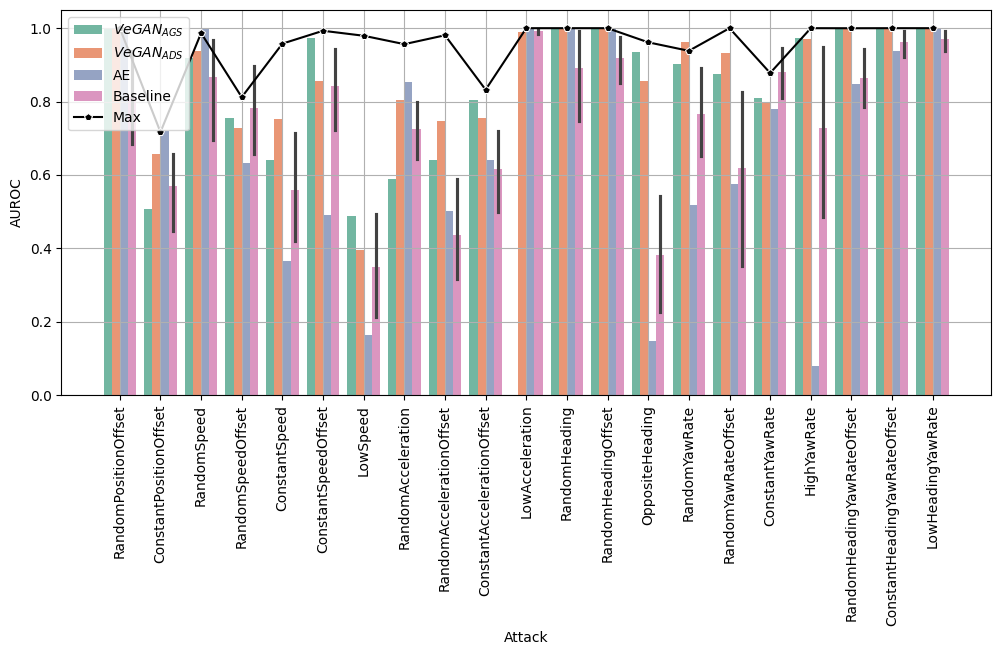

In [187]:
plt.figure(figsize=(12, 5))
sns.barplot(final_score_cut, x = 'Attack', y = 'AUROC', hue = 'Base', palette=sns.mpl_palette("Set2"),)
sns.lineplot(dis_ind_score_max, x = 'Attack', y = 'AUROC',  label = "Max", color = 'k', marker="p")
plt.xticks(rotation = 90)
plt.grid(True)

### Create Table for Comparison

In [188]:
combined_baseline = pd.DataFrame([])
for metric in ["AUROC", "AUPRC"]:
    df = final_score_cut[['Attack', metric, 'Model']]
    df.rename(columns={metric: "Score"}, inplace=True)
    df['Metric'] = metric
    combined_baseline = pd.concat([combined_baseline, df], ignore_index=True)

/tmp/ipykernel_234092/2730205150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={metric: "Score"}, inplace=True)
/tmp/ipykernel_234092/2730205150.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Metric'] = metric
/tmp/ipykernel_234092/2730205150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={metric: "Score"}, inplace=True)
/tm

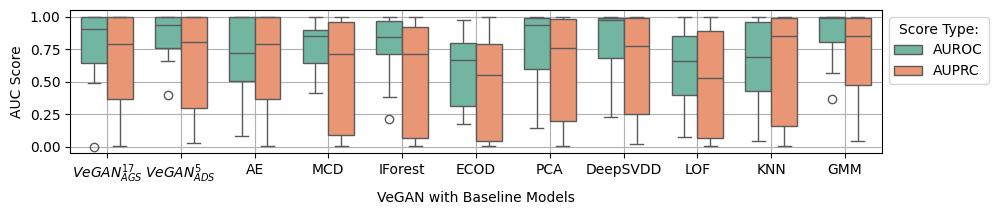

In [189]:
plt.figure(figsize=(10,2.25))
# sns.swarmplot(combined_baseline, x = 'Model', y = "Score", hue="Metric")
ax = sns.boxplot(combined_baseline, x = 'Model', y = "Score", hue = "Metric", palette=sns.mpl_palette("Set2"), width=.70, gap=0,)
plt.grid(True)
plt.xlabel("VeGAN with Baseline Models")
plt.ylabel("AUC Score")
# plt.title("Performance of VeGAN, compared to other MBDS baselines")
plt.legend(title = "Score Type:", ncols=1, bbox_to_anchor = (1.0, 1.0))
plt.xticks(rotation = 0)
plt.tight_layout()
plt.savefig(f"../artifacts/plots/baseline_final_boxplot_All.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/baseline_final_boxplot_All.pdf")
plt.show()

In [190]:
# Generate Table
data = final_score_cut[['Attack', 'AUROC', 'AUPRC', 'Model']]
baseline_table = pd.DataFrame([])
for attack in data['Attack'].unique():
    for base in data['Model'].unique():
        filter1 = data['Attack'] == attack
        filter2 = data['Model'] == base
        try:
            baseline_table.loc[attack, base]= data.where(filter1 & filter2).dropna()['AUROC'].values[0]
        except:
            baseline_table.loc[attack, base]= 0 #TODO: Fix here

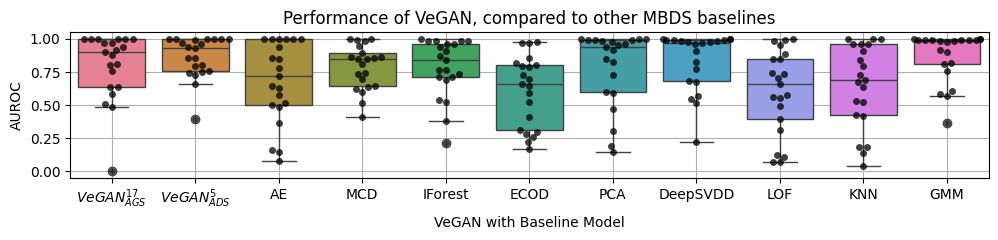

In [191]:
plt.figure(figsize=(10, 2.5))
sns.boxplot(baseline_table)
sns.swarmplot(baseline_table, color = 'k', alpha=0.75)
plt.xticks(rotation = 0)
plt.grid()
plt.xlabel("VeGAN with Baseline Model")
plt.ylabel("AUROC")
plt.title("Performance of VeGAN, compared to other MBDS baselines")
plt.tight_layout()
plt.savefig(f"../artifacts/plots/baseline_final_boxplot_All.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/baseline_final_boxplot_All.pdf")
plt.show()

In [192]:
# df_matrix = baseline_table
# df_matrix[f'$VeGAN_{{ADS}}^{{{ads_max_count}}}$'] - df_matrix['AE']
# df_matrix.loc["Average"] = df_matrix.mean(axis=0)
# df_matrix ['$\\Delta_{AE}$'] =df_matrix[f'$VeGAN_{{ADS}}^{{{ads_max_count}}}$'] - df_matrix['AE']
# df_matrix = np.round(df_matrix, 2)
# max_index = []
# for attak in df_matrix.values:
#     max_index.append(attak == max(attak))
# max_index = pd.DataFrame(max_index, columns=df_matrix.columns, index=df_matrix.index)
# df_matrix_copy = df_matrix.copy()
# for i in range(max_index.shape[0]):
#     for j in range(max_index.shape[1]):
#         if max_index.iloc[i,j] == True:
#             df_matrix_copy.iloc[i,j] = f"\\textbf{{{df_matrix.iloc[i,j]}}}"
# try:
#     print(df_matrix_copy.loc[cfg['selected_attacks'][1:] + ['Average']].astype(str).to_latex(index=True, formatters={"name": str.upper}, float_format="{:.3f}".format))
# except:
#     print(df_matrix_copy.to_latex(index=True, formatters={"name": str.upper}, float_format="{:.3f}".format))
